# <center>Logistic Regression and Evaluation Metrics</center>
<center>Shan-Hung Wu &amp; DataLab<br/>Fall 2023</center>

In [3]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.10.12
import os

from IPython.display import Image
from IPython.display import display

# numpy 1.23.5
import numpy as np

# pandas 1.5.3
import pandas as pd

# scikit-learn 1.2.2
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
# from cycler import cycler

# matplotlib  3.7.1
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [4]:
# load utility classes/functions e.g., plot_decision_regions()
import urllib.request

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py", "lab04lib.py")

from lab04lib import *

import warnings
warnings.filterwarnings("ignore")

<br>

In this lab, we will guide you through the practice of Logistic Regression.

<br>

## Logistic Regression
<br>

Logistic Regression is a classification algorithm in combination with a decision rule that makes dichotomous the predicted probabilities of the outcome. Currently, it is one of the most widely used classification models in Machine Learning.

As discussed in the lecture, Logistic Regression predicts the label $\hat{y}$ of a given point $\boldsymbol{x}$ by  

$$\hat{y}=\arg\max_{y}\mathrm{P}(y\,|\,\boldsymbol{x};\boldsymbol{w})$$

and the conditional probability is defined as

$$\mathrm{P}(y\,|\,\boldsymbol{x};\boldsymbol{w})=\sigma(\boldsymbol{w}^{\top}\boldsymbol{x})^{y'}[1-\sigma(\boldsymbol{w}^{\top}\boldsymbol{x})]^{(1-y')},$$

where $y'=\frac{y+1}{2}$. Let's first plot the logistic function $\sigma$ over $z=\boldsymbol{w}^{\top}\boldsymbol{x}$

$$\sigma\left(z\right)=\frac{\exp(z)}{\exp(z)+1}=\frac{1}{1+\exp(-z)}$$
<br>

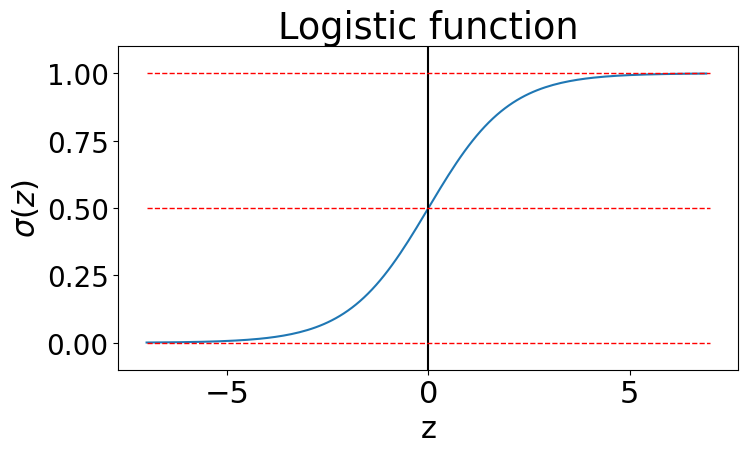

In [5]:
def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma = logistic(z)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(z, sigma)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.title('Logistic function')
plt.hlines(y=1.0, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.hlines(y=0.5, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.hlines(y=0, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.tight_layout()
for item in (ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('./output/fig-logistic.png', dpi=300)
plt.show()

<br>
We can see that $\sigma(z)$ approaches $1$ when $(z \rightarrow \infty)$, since $e^{-z}$ becomes very small for large values of $z$. Similarly, $\sigma(z)$ goes downward to $0$ for $ z \rightarrow -\infty$ as the result of an increasingly large denominator. The logistic function takes real number values as input and transforms them to values in the range $[0, 1]$ with an intercept at $\sigma(z) = 0.5$.


To learn the weights $\boldsymbol{w}$ from the training set $\mathbb{X}$ = $\{(x^1, y^1), (x^2, y^2), ..., (x^n, y^n)\}$, we can use ML estimation:

$$\arg\max_{\boldsymbol{w}}\log\mathrm{P}(\mathbb{X}\,|\,\boldsymbol{w}).$$

This problem can be solved by gradient ascent algorithm with the following update rule:

$$\boldsymbol{w}^{(t+1)}=\boldsymbol{w}^{(t)}+\eta\nabla_{\boldsymbol{w}}\log\mathrm{P}(\mathbb{X}\,|\,\boldsymbol{w}^{(t)}),$$

where

$$\nabla_{\boldsymbol{w}}\log\mathrm{P}(\mathbb{X}\,|\,\boldsymbol{w}^{(t)})=\sum_{i=1}^{N}[y^{(i)}-\sigma(\boldsymbol{w}^{(t)\top}\boldsymbol{x}^{(i)})]\boldsymbol{x}^{(i)}.$$

Therefore,

$$\boldsymbol{w}^{(t+1)}=\boldsymbol{w}^{(t)}+\eta\cdot[\boldsymbol{y}-\sigma(\boldsymbol{w}^{(t)}\boldsymbol{x})]\boldsymbol{x}.$$

Once $\boldsymbol{w}$ is solved, we can then make predictions by

$$\hat{y}=\arg\max_{y}\mathrm{P}(y\,|\,\boldsymbol{x};\boldsymbol{w})=\arg\max_{y}\{\sigma(\boldsymbol{w}^{\top}\boldsymbol{x}),1-\sigma(\boldsymbol{w}^{\top}\boldsymbol{x})\}=\mathrm{sign}(\boldsymbol{w}^{\top}\boldsymbol{x}).$$

Logistic Regression is very easy to implement but performs well on linearly separable classes (or classes close to linearly separable). Similar to the Perceptron and Adaline, the Logistic Regression model is also a linear model for binary classification. We can relate the Logistic Regression to our previous Adaline implementation. In Adaline, we used the identity function as the activation function. In Logistic Regression, this activation function simply becomes the logistic function (also called as sigmoid function) as illustrated below:

<img src="fig-logistic-regression.png" style="width: 500px;"/>
<br>


### Predicting Class-Membership Probability
<br>
One benefit of using Logistic Regression is that it is able to output the **class-membership probability** (i.e., probability of a class to which a point $\boldsymbol{x}$ belongs) via $\sigma(\boldsymbol{w}^{\top}\boldsymbol{x})$ and $1-\sigma(\boldsymbol{w}^{\top}\boldsymbol{x})$.

In fact, there are many applications where we are not only interested in predicting class labels, but also in estimating the class-membership probability. For example, in weather forecasting, we are interested not only if it will rain tomorrow but also the chance of raining. Similarly, when diagnosing disease we usually care about the chance that a patient has a particular disease given certain symptoms. This is why Logistic Regression enjoys wide popularity in the field of medicine.

### Training a Logistic Regression Model with Scikit-learn

Scikit-learn implements a highly optimized version of logistic regression that also supports multiclass classification off-the-shelf. Let's use it to make predictions on the standardized Iris training dataset.

NOTE: Logistic Regression, like many other binary classification models, can be easily extended to multiclass classification via [One-vs-All](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest) or other similar techniques.
<br>

In [6]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

# for simplicity, consider only two features and two classes

X = df[['Petal length', 'Petal width']].values[50:150]
y, y_label = pd.factorize(df['Class label'].values[50:150])

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=1)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(y_label)))

# Standardize X

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [0 1] (mapped from ['Iris-versicolor' 'Iris-virginica'])


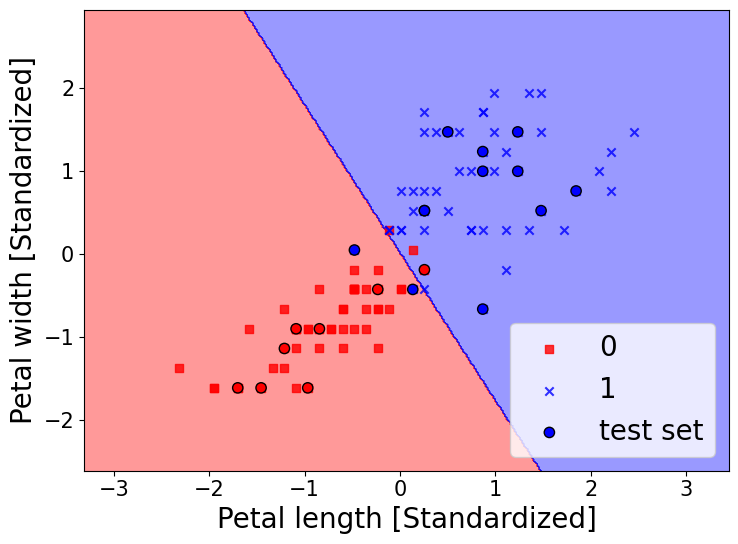

In [7]:
lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

# plot decision regions
fig, ax = plt.subplots(figsize=(8,6))
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(y_train.size,
                                                    y_train.size + y_test.size))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='lower right')
plt.tight_layout()
plt.legend(loc=4, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-boundray-2.png', dpi=300)
plt.show()

<br>
The `Logistic Regression` class can predict the class-membership probability via the `predict_proba()` method. For example, we can predict the probabilities of the first testing point:

In [8]:
test_idx = 1
print('Correct label: %s\n' % y_label[y_test[test_idx]])

prob = lr.predict_proba(X_test_std[test_idx, :].reshape(1, -1))

print('Prob for class %s: %.2f' % (y_label[0], prob[:, 0]))
print('Prob for class %s: %.2f' % (y_label[1], prob[:, 1]))

Correct label: Iris-virginica

Prob for class Iris-versicolor: 0.01
Prob for class Iris-virginica: 0.99


The `prob` array tells us that the model predicts a 99% chance that the sample belongs to the Iris-Virginica class, and a 1% chance that the sample is a Iris-Versicolor flower.
<br>
<br>

### Regularization
<br>
One way to regularize a logistic regression classifier is to add a **weight decay** term in the objective (or cost function), as in Ridge regression:

$$\arg\max_{\boldsymbol{w}}\log\mathrm{P}(\mathbb{X}\,|\,\boldsymbol{w})-\frac{\alpha}{2}\Vert\boldsymbol{w}\Vert^2,$$

where $\alpha > 0$ is a hyperparameter that controls the trade-off between maximizing the log likelihood and minimizing the weight. Note that the `Logistic Regression` class implemented in Scikit-learn uses the hyperparameter $C=1/\alpha$ due to convention.

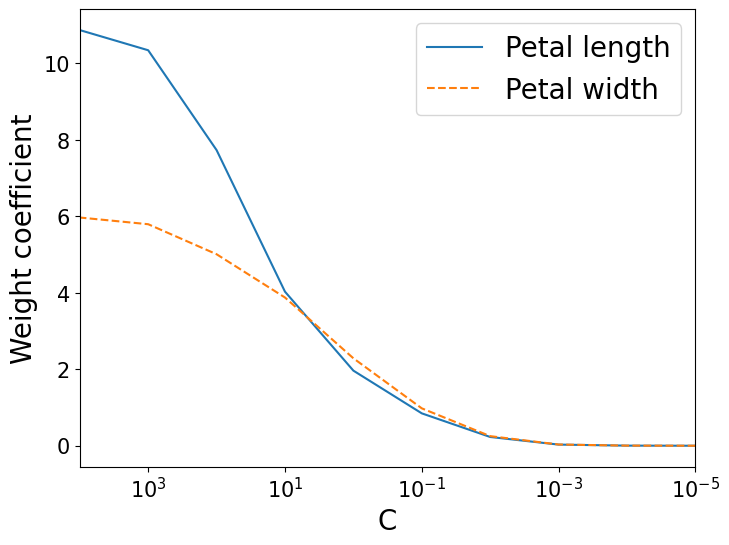

In [9]:
weights, params = [], []
for c in np.arange(-5, 5, dtype='float32'):
    lr = LogisticRegression(C = 10**c, random_state = 0, solver = "liblinear")
    lr.fit(X_train_std, y_train)
    # get the coefficients of w
    weights.append(lr.coef_[0])
    params.append(10**c)

fig, ax = plt.subplots(figsize=(8,6))
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1],
         label='Petal width', linestyle='--')
plt.xlim(10**4, 10**-5)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Weight coefficient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend(loc=1, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-c.png', dpi=300)
plt.show()

## Evaluation Metrics for Binary Classifiers

So far, we evaluate the performance of a classifier using the **accuracy** metric. Although accuracy is a general and common metric, there are several other evaluation metrics that allow us to quantify the performance of a model from different aspects.

### Confusion Matrix

Before we get into the details of different evaluation metrics, let's print the so-called **confusion matrix**, a square matrix that reports the counts of the true positive, true negative, false positive, and false negative predictions of a classifier, as shown below:

<img src="fig-confusion.png" style="width: 400px;"/>

<br>
The confusion matrix of our logistic regressor over the Iris dataset is shown as follows:

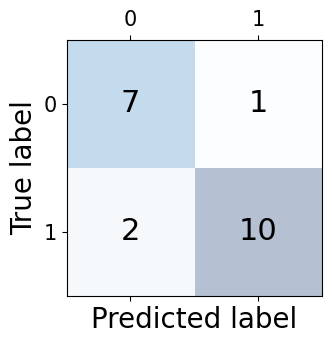

In [10]:
lr = LogisticRegression(random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

The meaning of each entry in the above confusion matrix is straightforward. For example, the cell at $(1,0)$ means that $2$ positive testing points are misclassified as negative. Confusion matrix helps us know not only the count of **how many** errors but **how** they are wrong. Correct predictions counts into the diagonal entries. A good performing classifier should have a confusion matrix that is a diagonal matrix which means that the entries outside the main diagonal are all zero.
<br>
The **error rate (ERR)** and **accuracy (ACC)** we have been using can be defined as follows:

$$ERR = \frac{FP+FN}{TP + TN + FP + FN},\enspace\text{ (the lower, the better)}$$

$$ACC = \frac{TP+TN}{TP + TN + FP + FN} = 1-ERR.\enspace\text{ (the higher, the better)}$$


### True and False Positive Rate

The **true positive rate (TPR)** and **false positive rate (FPR)** are defined as:

$$TPR = \frac{TP}{TP + FN}.\enspace\text{ (the higher, the better)}$$

$$FPR = \frac{FP}{FP + TN},\enspace\text{ (the lower, the better)}$$

TPR and FPR are metrics particularly useful for tasks with **imbalanced classes**. For example, if we have 10% positive and 90% negative examples in the training set, then a dummy classifier that always give negative predictions will be able to achieve 90% accuracy. The accuracy metric is misleading in this case. On the other hand, by checking the TPR which equals to 0%, we learn that the dummy classifier is not performing well.

### Precision, Recall, and $F_1$-Score
The **Precision (PRE)** and **recall (REC)** metrics are defines as:

$$PRE = \frac{TP}{TP + FP},\enspace\text{ (the higher, the better)}$$

$$REC = \frac{TP}{TP + FN} = TPR.\enspace\text{ (the higher, the better)}$$

Basically, PRE means "how many points predicted as positive are indeed positive;" while REC refers to "how many positive points in the ground truth are successfully identified as positive." PRE and REC are useful metrics if we care specifically about the performance of positive predictions.

In practice, we may combine PRE and REC into a single score called the **$F_1$-score**:

$$F_1 = 2\frac{(PRE * REC)}{PRE+REC},\enspace\text{ (the higher, the better)}$$

which reaches its best value at $1$ and worst at $0$.

## Evaluation Metrics for Soft Classifiers
Many classifiers, such as Adaline and Logistic Regression, can make "soft" predictions (i.e., real values instead of the "hard" 1 or -1). We may "harden" the soft predictions by defining a **decision threshold $\theta$**. For example, suppose a classifier makes soft predictions in range $[-1,1]$ that are sorted as follows:

<img src="fig-roc-threshold.png" style="width: 120px;"/>

We can define a threshold $\theta=0.8$ such that points with scores larger/smaller than $0.8$ become positive/negative outputs. It is clear that the performance of the classifier will vary as we use different values for threshold.

### Receiver Operating Characteristic (ROC) Curve
The **receiver operator characteristic (ROC)** curve measures the performance of a classifier at **all** possible thresholds. We can draw an ROC curve by following the steps:

1. Rank the soft predictions from highest to lowest;
2. For each indexing threshold $\theta$ that makes the first $\theta$ points positive and the rest negative, $\theta=1,\cdots,\vert\mathbb{X}\vert$, calculate the $TPR^{(\theta)}$ and $FPR^{(\theta)}$;
3. Draw points $(TPR^{(\theta)},FPR^{(\theta)})$ in a 2-D plot and connect the points to get an ROC curve.

Let's plot the ROC curve of our logistic regressor:

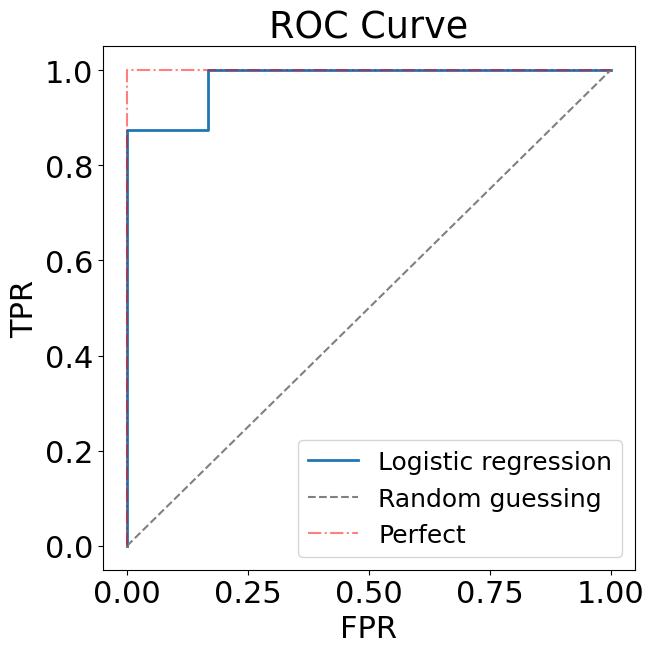

In [11]:
lr = LogisticRegression(random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

fig = plt.figure(figsize=(7,7))

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

probas = lr.predict_proba(X_test_std)

## we use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-roc-lg.png', dpi=300)
plt.show()


### How does the ROC curve of a "good" classifier look like?
The ROC curve of a perfect classifier would have a line that goes from bottom left to top left and top left to top right. On the other hand, if the ROC curve is just the diagonal line then the model is just doing random guessing. Any useful classifier should have an ROC curve falling between these two curves.

### Model Comparison
ROC curves are useful for comparing the performance of different classifiers over the same dataset. For example, suppose we have three classifiers $A$, $B$, and $C$ and their respective ROC curves, as shown below:

<img src="fig-roc-compare.png" style="width: 250px;"/>

It is clear that the classifiers $B$ and $C$ are better than $A$. But how about $B$ and $C$? This can also be answered by ROC curves:

- If we tolerate no more than 10% FPR, we should pick $B$ at an indexing threshold $\theta=0.15\vert\mathbb{X}\vert$ to get 60% TPR;
- If we tolerate 40% FPR, then pick $C$ at $\theta=0.4\vert\mathbb{X}\vert$, which gives 90% TPR.
<br>
<br>

### Area Under the Curve (AUC)

We can reduce an ROC curve to a single value by calculating the **area under the curve (AUC)**. A perfect classifier has $AUC=1.0$, and random guessing results in $AUC=0.5$. It can be shown that AUC is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

Let's compute the AUC of our logistic regressor:

In [12]:
print('AUC: %.2f' % auc(fpr, tpr))

AUC: 0.98


That's a pretty high score!
<br>
<br>

## Evaluation Metrics for Multiclass Classification
<br>

In multiclass classification problem, we can extend the above metrics via **one-vs-all** technique, where we treat one class as "positive" and the rest as "negative" and compute a score for the class. If there are $K$ classes, then we compute $K$ scores, one for each class.  However, if we just want to have a single final score, we need to decide how to combine these scores.

Scikit-learn implements the **macro** and **micro averaging** methods. For example, the micro-average of $K$ precision scores is calculated as follows:

$$PRE_{micro} = \frac{TP^{(1)} + \cdots + TP^{(K)}}{P'^{(1)} + \cdots + P'^{(K)}};$$

while the macro-average is simply the average of individual PRE's:

$$PRE_{macro} = \frac{PRE^{(1)} + \cdots + PRE^{(K)}}{K}$$

Micro-averaging is useful if we want to weight each data point or prediction equally, whereas macro-averaging weights all classes equally. Macro-average is the default in Scikit-learn.

Let's train a multiclass logistic regressor and see how it performs:

#Training data points: 16 + 33 + 31 = 80
#Testing data points: 4 + 17 + 19 = 40
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'])


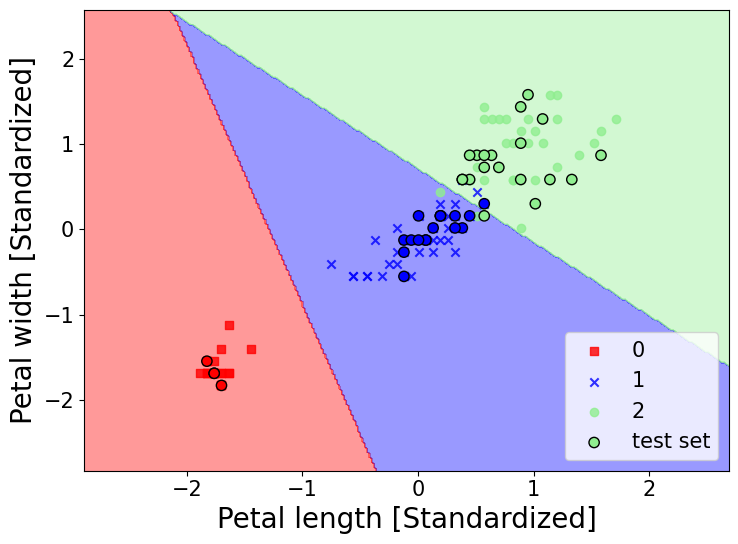

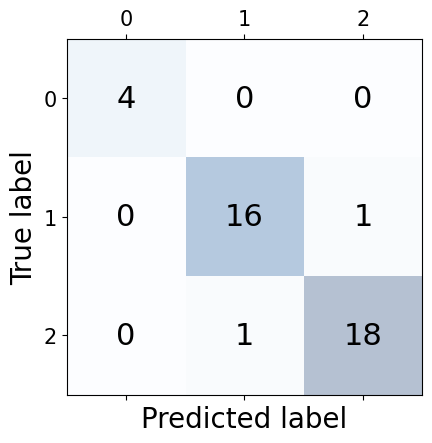

[Precision]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96

[Recall]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96

[F1-score]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96


In [13]:
# prepare datasets

X = df[['Petal length', 'Petal width']].values[30:150,]
y, y_label = pd.factorize(df['Class label'].values[30:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

print('#Training data points: %d + %d + %d = %d' % ((y_train == 0).sum(),
                                                    (y_train == 1).sum(),
                                                    (y_train == 2).sum(),
                                                     y_train.size))
print('#Testing data points: %d + %d + %d = %d' % ((y_test == 0).sum(),
                                                    (y_test == 1).sum(),
                                                    (y_test == 2).sum(),
                                                     y_test.size))
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(y_label)))

# standarize X

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# training & testing

lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear", multi_class = "ovr")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

# plot decision regions
fig, ax = plt.subplots(figsize=(8,6))

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc=4, prop={'size': 15})
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-boundray-3.png', dpi=300)
plt.show()

# plot confusion matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-confusion-3.png', dpi=300)
plt.show()

# metrics

print('[Precision]')
p = precision_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f, %.2f' % (p[0], p[1], p[2]))
p = precision_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % p)
p = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % p)

print('\n[Recall]')
r = recall_score(y_true=y_test, y_pred=y_pred,average=None)
print('Individual: %.2f, %.2f, %.2f' % (r[0], r[1], r[2]))
r = recall_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % r)
r = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % r)

print('\n[F1-score]')
f = f1_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f, %.2f' % (f[0], f[1], f[2]))
f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % f)
f = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % f)

We can see that the micro average reports more conservative scores. This is because it takes into account the class size. In our testing set, the first class is smaller than the others so its score (1.00) contributes less to the final score.
<br>

# <center>Assignment</center>

## Goal
Predict the presence or absence of cardiac arrhythmia in a patient

## Read this note carefully
- Submit to **eeclass** with your code file, the filename format should be ```Lab06_{student_id}.ipynb```. The notebook should contain
    1. Loading of dataset
    2. Splitting of dataset to training and testing data (test_size = 20% of the whole dataset)
    3. Building of a self-designed Logistic Regression model (Complete the TODO parts provided below)
    4. Plotting the loss curve.
    5. Plotting of the confusion matrix. (**Label 0 as positive**)
    6. Computing the F1-score of this confusion matrix. The F1-score should be at least 0.75
- Deadline: **2023-10-26(Thr) 23:59**
- Please make sure that we can rerun your code

## Dataset
The [Arrhythmia](https://archive.ics.uci.edu/ml/datasets/Arrhythmia) dataset from UCI repository contains 280 variables collected from 452 patients. Its information helps in distinguishing between the presence and absence of cardiac arrhythmia and in classifying arrhytmia in one of the 16 groups. In this homework, we will just focus on building a Logistic Regression model that  can classify between the presence and absence of arrhythmia.<br><br>

Original class 1 refers to 'normal' ECG which we will regard as 'absence of arrhythmia' and the rest of the classes will be 'presence of arrhythmia'.

In [14]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


How big is the dataset?

In [15]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


The last column of the dataset is the class label. It contains the 16 ECG classifications:

In [16]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16])

Let's make that column (class label) dichotomous.<br>
Value is 0 if ECG is normal, 1 otherwise

In [17]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

Are the groups balanced?

In [18]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

Some columns have missing values denoted as '?'<br>
To make the preprocessing simpler, let's just retain the columns with numeric values.

In [19]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [20]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [21]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [22]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [23]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Please continue working from here.

In [24]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            self.w_[1:] += self.eta * gradient_weights
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""
        # TODO
        pass

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        return errors.dot(X), errors.sum()

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        pass

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        pass